
# Exoplanet Classification


## 1. Introduction

In this repository we compare multiple machine learning algorithms for binary classification.

The methods will be tested on the task of binary classification of exoplanet candidates found by NASA’s Kepler spacecraft, found [here](https://exoplanetarchive.ipac.caltech.edu).

An exoplanet is a planet outside of the solar system (i.e. does not orbit
the sun). The spacecraft first identifies possible signs of exoplanets, referred to as Kepler Object
of Interest (KOI). Not all KOIs are actual exoplanets however, some are false positives of different
natures. The task performed is to classify KOIs between confirmed exoplanets and false positives. Each
observation corresponds to a KOI and the features are estimates of the physical properties of the
(possible) exoplanet (radius, temperature, features of the host star, etc).

## 2. Imports and Input Reading

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn import svm
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,precision_score,recall_score



In [2]:
warnings.simplefilter("ignore")
sns.set(rc={'figure.figsize':(10,10)})

Reading the dataset

In [3]:
df = pd.read_csv("koi_data.csv")
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


## Pre-processing

Changing categoric data to discrete values

In [4]:
# koi_disposition column is now 1 if it's confirmed or 0 otherwise
data = df.copy()
data["koi_disposition"] = df["koi_disposition"].apply(lambda x: 1 if (x=='CONFIRMED') else 0)

data.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,1,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,1,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,0,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,1,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,0,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [5]:
# changing kepoi_name to numeric values
data["kepoi_name"] = data.index
data.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,0,1,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,1,1,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,2,0,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,3,1,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,4,0,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Feature Selection

In [6]:
# feature selection
TARGET = "koi_disposition"
NAME = "kepoi_name"
N_FEATURES = len(data.columns) - 2 

features = list(data.columns)
features.remove(TARGET)
features.remove(NAME) #removes name from features list

skb = feature_selection.SelectKBest(feature_selection.f_classif, N_FEATURES)
skb = skb.fit(data[features], data[TARGET])


## Data Normalization

In [7]:
data[features] = data[features] - data[features].mean()
data[features] = data[features]/data[features].std()
data["kepoi_name"] = df.index # returning to original index

## Train/Test Split and Model Evaluation

In [8]:
# method performs k-fold cross validation and returns train/test accuracy, 
# precision and recall
index = data["kepoi_name"]
k = 5
def model_eval(model,data):
    results = []
    kfold = KFold(n_splits = k)
    for train_index,test_index in kfold.split(index):
        # train/test split
        x_train = skb.transform(data.loc[train_index, features])
        y_train = (data.loc[train_index, TARGET])
        x_test = skb.transform(data.loc[test_index, features])
        y_test = (data.loc[test_index, TARGET])
        model.fit(x_train,y_train)
        # precision, recall and accuracy       
        pred = model.predict(x_test)
        acc = accuracy_score(y_test,pred)
        train_acc = model.score(x_train,y_train)
        precision = precision_score(y_test,pred) 
        recall = recall_score(y_test,pred)

        results.append([acc,train_acc,precision,recall])
    # using a dataframe to sotre informations and return k-fold metrics
    df_results = pd.DataFrame(results,columns=["acc","train_acc","precision","recall"]) #dataframe que contem todas as acuracias e erri de treino
    return df_results["acc"].mean(),df_results["train_acc"].mean(), df_results["precision"].mean(), df_results["recall"].mean()
        
        


  ## Graphs

In [ ]:
def graph_plot(df,title):
    plt.plot(df["model_index"], df['acc'],label='acc')
    plt.plot(df["model_index"], df["train_acc"],label='acc de treino')
    plt.title(title)
    plt.axhline(c="r",y=naive_acc,label='Naive Bayes')
    plt.legend()
    plt.show()

  ## Best Models
  
We create a dataframe to store the best models' results

In [ ]:
col = ["acc","train_acc","parameters","param_value","precision","recall"]
best_index = ["naive_bayes","decision_tree","svm","knn","random_forest","gt_boosting"]
best_models = pd.DataFrame(columns=col,index=best_index)


In [ ]:
# Append to best models dataframe
def add_to_best_models(row,bm_acc,bm_train_acc,bm_prec,bm_recall,bm_param=None,bm_param_val=None):
    best_models.loc[row]["acc"] = bm_acc
    best_models.loc[row]["train_acc"] = bm_train_acc
    best_models.loc[row]["parameters"] = bm_param
    best_models.loc[row]["param_value"] = bm_param_val
    best_models.loc[row]["precision"] = bm_prec
    best_models.loc[row]["recall"] = bm_recall

  ##  8. Experimental Model Evaluation

We'll compare the following machine learning algorithms:
1. Naive Bayes
2. Decision Tree 
3. SVM
4. K-NN
5. Random Forest
6. Gradient Tree Boosting



#### 8.1. Naive Bayes

We'll use Naive Bayes as a experimental baseline

In [ ]:
gnb = GaussianNB()
naive_acc, naive_train_acc, precision, recall = model_eval(gnb,data)

# We only create one NB model, so it is our best one
add_to_best_models("naive_bayes",naive_acc,naive_train_acc,precision,recall)

aux_nb = best_models.loc["naive_bayes"][["acc","train_acc","precision","recall"]]
aux_nb

acc          0.916176
train_acc    0.916858
precision    0.675045
recall       0.862582
Name: naive_bayes, dtype: object

Naive Bayes é um algoritmo não paramétrico e que assume independências das features. Além disso, por ser não paramétrico, funciona bem com pouca quantidade de dados. Os resultados obtidos para o Naive Bayes serão utilizados como baseline para os demais experimentos. Obtemos acurácia alta, o que indica que os dados são simples, além de indicar que as features são independentes. 

#### 8.2. Decision Tree

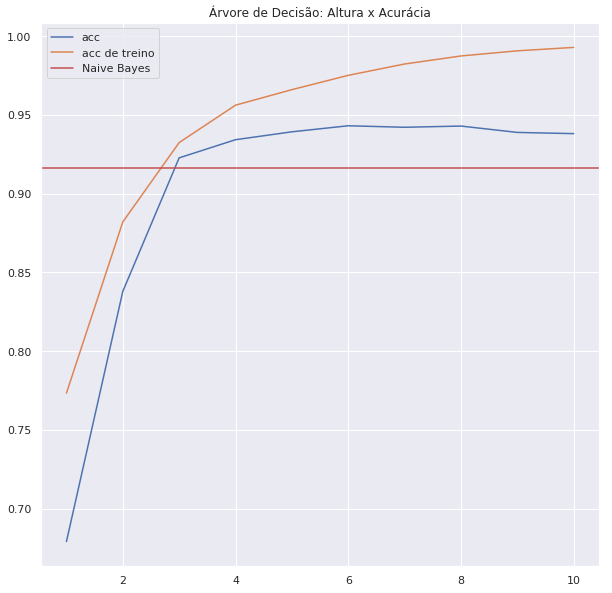

In [ ]:
results = []
# testando com tamanho ilimitado
dec_tree = tree.DecisionTreeClassifier(max_depth=None)
acc, train_acc, precision, recall = model_eval(dec_tree,data)
results.append([acc, train_acc])

dec_tree = 11
aux_acc = 0
aux_train_acc = 0
aux_max_depth = 0
aux_precision = 0
aux_recall = 0

for max_depth in range(1,dec_tree):
    dec_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
    acc, train_acc, precision,recall = model_eval(dec_tree,data)
#   selecionando o melhor modelo
    if acc > aux_acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_max_depth = max_depth
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc,max_depth])
    
add_to_best_models("decision_tree",aux_acc,aux_train_acc,precision,recall,"max_depth",aux_max_depth)


df_dt = pd.DataFrame(results,columns=["acc","train_acc","model_index"])
title = "Árvore de Decisão: Altura x Acurácia"
graph_plot(df_dt,title)


Para a árvore de decisão, é variado o tamanho máximo para sua altura. Aqui, observamos que, à partir de árvores de altura 8, os modelos começam a apresentar overfitting. Além disso, árvores com altura ilimitada ou menor que 3 causam underfitting, não conseguindo ultrapassar o baseline obtido com o Naive Bayes.

#### 8.3. SVM

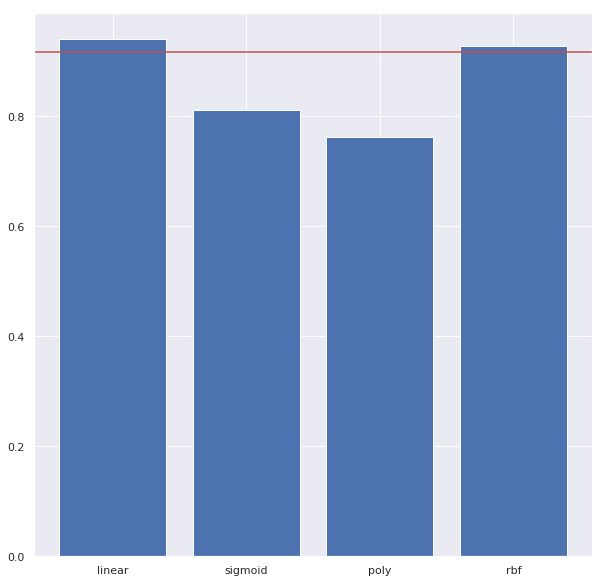

In [ ]:
kernel_list = ["linear","sigmoid","poly","rbf"]
results = []
c = 1
aux_acc = 0
aux_train_acc = 0
aux_kernel = ''
aux_precision = 0
aux_recall = 0

for kernel in kernel_list:
    svm_classifier = svm.SVC(c,kernel,gamma='auto',probability=True)
    acc, train_acc, precision, recall = model_eval(svm_classifier, data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_kernel = kernel
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc])
df_svm = pd.DataFrame(results,columns=["acc","train_acc"])

add_to_best_models("svm",aux_acc,aux_train_acc,aux_precision,aux_recall,"kernel",aux_kernel)

# Especialmente no SVM, por ser um grafico de barras, nao usaremos
# a funcao graph_plot() criada
plt.bar(kernel_list,df_svm["acc"])
plt.axhline(naive_acc,c="r")
plt.show()

Para o SVM, é variado o kernel que será utilizado para alterar a representação dos dados, a fim de classficá-los de forma melhor. Ao avaliarmos os modelos criados com kernels distintos, é possível observar que apenas dois deles ultrapassaram o baseline obtido com o Naive Bayes. Dentre os 4 kernels avaliados, obtivemos o melhor resultado com o kernel linear, que demonstra que os dados são quase linearmente separáveis, portanto, não é necessário mudar sua representação para obter bons resultados

#### 8.4. K-NN

In [ ]:
results = []
aux_acc = 0
aux_train_acc = 0
aux_k = 0
knn_range = 20
aux_precision = 0
aux_recall = 0

for i in range(1,knn_range,2):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    acc, train_acc, precision, recall = model_eval(knn,data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_k = i
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc,i])

df_knn = pd.DataFrame(results, columns=["acc","train_acc","model_index"])

add_to_best_models("knn",aux_acc,aux_train_acc,aux_precision,aux_recall,"n_neighbors",aux_k)

title="KNN: K x Acurácia"
graph_plot(df_knn,title)

Para o modelo K-NN, é variada a quantidade de vizinhos utilizada para realizar o agrupamento. Dessa forma, ao utilizar uma grande quantidade de vizinhos, o modelo pode apresentar overfitting, pois torna-se tão generalista que não consegue separar os dados, o que pode ser observado no gráfico acima em que, conforme aumentamos a quantidade de vizinhos, a acurácia diminui. 

#### 8.5. Random Forest

In [ ]:
N = 25
max_depth = 5
results = []
aux_acc = 0
aux_train_acc = 0
aux_precision = 0
aux_recall = 0

aux_N = 0
for n in range(1,N+1):
    random_forest = ensemble.RandomForestClassifier(n_estimators=N, max_depth=max_depth)
    acc, train_acc, precision, recall = model_eval(random_forest,data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_N = n
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc,n])


add_to_best_models("random_forest",aux_acc,aux_train_acc,aux_precision,aux_recall,"n_estimators",aux_N)

df_rf = pd.DataFrame(results,columns=["acc","train_acc","model_index"])
title = "Random Forest: # Árvores x Acurácia"
graph_plot(df_rf,title)


Para o modelo Random Forest, é variada a quantidade de árvores que serão utilizadas por modelo. Além disso, fixamos a altura máxima de todas as árvores para 5. Random Forest baseia-se no conceito de bagging, utilizando amostras do dado a fim de atacar problemas causados devido à variância destes, tornando-se robusto à overfitting. Essa robustez pode ser observada no gráfico acima, em que todos os modelos gerados apresentam acurácia entre 0.93 e 0.94, sem tendência clara de queda


#### 8.6. Gradient Tree Boosting

In [ ]:
results = []
gtb_range = 30
aux_acc = 0
aux_train_acc = 0
aux_estimators = 0
aux_precision = 0
aux_recall = 0
for n_estimators in range(1,gtb_range):
    gt_boosting = ensemble.GradientBoostingClassifier(n_estimators=n_estimators)
    acc, train_acc, precision,recall = model_eval(gt_boosting,data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_estimators = n_estimators
        aux_recall = recall
        aux_precision = precision
    results.append([acc,train_acc,n_estimators])

add_to_best_models("gt_boosting",aux_acc,aux_train_acc,aux_precision,aux_recall,"n_estimators",aux_estimators)

df_gtb = pd.DataFrame(results,columns=["acc","train_acc","model_index"])
title = "Gradient Tree Boosting: Iterações x Acurácia"
graph_plot(df_gtb,title)


Para o método Gradient Tree Boosting, variamos o número de iterações realizadas por cada modelo. Este algoritmo baseia-se no conceito de boosting, que, ao utilizar varios modelos simples para criar um modelo forte, torna-se robusto contra overfitting, o que pode ser observado no gráfico obtido, pois, conforme aumentamos o número de iterações, a acurácia apenas tende a subir.

   ## <p style="text-align: center;">  9. Resultados </p>  

### 9.1 Avaliação Comparativa

Agora, temos um dataframe com informações sobre os melhores modelos para cada método de classificação

In [ ]:
best_models

Abaixo, um gráfico de barras que resume de forma concisa os resultados encontrados

In [ ]:
best_models.plot.barh(y=['acc','train_acc',"precision","recall"], 
             xlim=(0.6,1.0),
             title='Avaliação Comparativa')
plt.show()

**Naive bayes**: Por ser mais simples, sua precisão tende a ser mais baixa que a dos outros modelos, mas o recall contra-balanceia este resultado, devido à simplicidade do problema em questão e à quantidade pequena de entradas, resultando em um bom valor de acurácia. Apesar de ser um modelo simples, ultrapassa os resultados obtidos para o K-NN.

**Decision Tree**: Também faz parte da categoria de modelos mais simples, mas é mais robusto que o Naive Bayes, por isso, apresenta melhora significativa na acurácia e na precisão, quando comparada a este, mantendo um recall similar.

**SVM**: É um dos modelos mais complexos e robustos dentre os avaliados neste trabalho. Congruentemente, apresentou o segundo maior recall dentre todos os modelos avaliados, contudo, demonstrou precisão mediana, que pode significar que a margem do modelo é muito grande, ocasionando em mais falsos positivos que o esperado.

**KNN**: Este modelo não superou o baseline criado com o Naive Bayes. Isto pode ser explicado devido à simplicidade e especificidade do dado em questão. Obteve o maior recall de todos os modelos, mas baixa precisão, menor que o baseline. Este resultado está associado à quantidade de vizinhos escolhida para realizar o agrupamento.

**Random Forest**: É um aprimoramento do modelo de decision tree e, portanto, mais robusto. Desta forma, o Random Forest obtêm maior acurácia que a Decision Tree, apesar de serem similares.

**Gradient Tree Boosting**: Por ser um modelo baseado no conceito de boosting, é mais generalista, desta forma, apresentou o segundo menor recall dentro todos os modelos. Contudo, obteve a melhor acurácia dentre todos os modelos

### 9.2 Curva ROC

Na célula abaixo, são instanciados os modelos com os melhores parâmetros obtidos na avaliação experimental

In [ ]:
C=1
N=5
nb = GaussianNB()
svm_classifier = svm.SVC(C,kernel=best_models.loc["svm"]["param_value"],gamma='auto',probability=True)
decision_tree = tree.DecisionTreeClassifier(max_depth=int(best_models.loc["decision_tree"]["param_value"]))
knn = neighbors.KNeighborsClassifier(n_neighbors=int(best_models.loc["knn"]["param_value"]))
random_forest = ensemble.RandomForestClassifier(n_estimators=N, max_depth=int(best_models.loc["random_forest"]["param_value"]))
gt_boosting = ensemble.GradientBoostingClassifier(n_estimators=int(best_models.loc["gt_boosting"]["param_value"]))

# a lista abaixo permite iterar pelos modelos no momento de gerar a curva ROC
models = [nb, svm_classifier, decision_tree, knn, random_forest, gt_boosting]


Abaixo, criamos uma função para plotar a curva roc para qualquer modelo.

In [ ]:
sns.set(rc={'figure.figsize':(5,5)}) # resetando o tamanho dos graficos, visto que sao 6 em seguida

# lista de nomes de metodos para realizar o plot dinamico das curvas ROC de cada metodo
methods_names = ["Naive Bayes","SVM","Decision Tree","K-NN","Random Forest","Gradient Tree Boosting"]

# definimos a funcao abaixo que plota a curva roc para qualquer modelo
def plot_roc(model, title):
    all_probs = []
    all_y_test = []
    index = data["kepoi_name"]
    k=5
    kfold = KFold(n_splits = k)
    for train_index,test_index in kfold.split(index):
        x_train = skb.transform(data.loc[train_index, features])
        y_train = (data.loc[train_index, TARGET])

        x_test = skb.transform(data.loc[test_index, features])
        y_test = (data.loc[test_index, TARGET])
        model.fit(x_train,y_train)

        pred = model.predict(x_test).tolist()
        probs = model.predict_proba(x_test)[:,1].tolist()
        all_probs += probs
        all_y_test += y_test.values.tolist()
    fpr, tpr, thresholds = roc_curve(all_y_test, all_probs)
    sns.lineplot(fpr,tpr,label="ROC (AUC = %0.2f )" %(round(auc(fpr,tpr), 4)))    
    plt.title(title)
    plt.show()
    

for j in range(len(models)):
    plot_roc(models[j], "ROC curve: " + methods_names[j])
